In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch,jovian, torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [50]:
#speeds up the ipy notebook intellisense
%config Completer.use_jedi = False

project_name='insurance-linear-regression-pytorch' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
dataframe_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [7]:
your_name = 'Naman Singhal' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
160,42,female,25.80200,0,yes,23270.089540
1326,42,female,31.88390,0,no,7684.523217
544,54,male,29.30370,0,no,11152.334891
624,59,male,27.92145,0,no,13221.279423
914,33,male,23.86685,2,no,5730.683666


In [10]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 160 to 827
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 69.5+ KB


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [11]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [12]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [13]:
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')

In [14]:
input_cols = ['age',  'bmi', 'children', 'sex','smoker']
input_cols

['age', 'bmi', 'children', 'sex', 'smoker']

**Q: Which of the input columns are non-numeric or categorical variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [15]:
categorical_cols = ['sex','smoker']

**Q: What are the column titles of output/target variable(s)?**

In [16]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [17]:
# Write your answer here
print('''Column - Charges
Minimum Value - {:.2f}
Maximum Value - {:.2f}
Average Value - {:.2f}'''.format(min(dataframe.charges),max(dataframe.charges),dataframe.charges.mean()))

Column - Charges
Minimum Value - 1222.84
Maximum Value - 69509.77
Average Value - 14411.98


(array([270., 239., 195., 183.,  70.,  55.,  45.,  39.,  23.,   9.,  23.,
         31.,  27.,  26.,  21.,   9.,   1.,   1.,   2.,   2.]),
 array([ 1222.842551  ,  4637.18875   ,  8051.53494899, 11465.88114798,
        14880.22734698, 18294.57354598, 21708.91974497, 25123.26594397,
        28537.61214296, 31951.95834196, 35366.30454095, 38780.65073995,
        42194.99693894, 45609.34313794, 49023.68933693, 52438.03553593,
        55852.38173492, 59266.72793392, 62681.07413291, 66095.4203319 ,
        69509.7665309 ]),
 <a list of 20 Patch objects>)

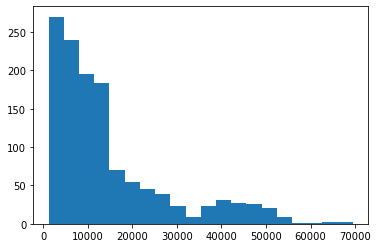

In [18]:
plt.hist(dataframe['charges'],bins=20)

In [19]:
dataframe.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [20]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [21]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[42.     , 25.802  ,  0.     ,  0.     ,  1.     ],
        [42.     , 31.8839 ,  0.     ,  0.     ,  0.     ],
        [54.     , 29.3037 ,  0.     ,  1.     ,  0.     ],
        ...,
        [40.     , 24.6962 ,  1.     ,  0.     ,  0.     ],
        [55.     , 36.58355,  3.     ,  1.     ,  0.     ],
        [36.     , 27.18425,  1.     ,  1.     ,  1.     ]]),
 array([[23270.08954  ],
        [ 7684.523217 ],
        [11152.334891 ],
        ...,
        [ 7714.136446 ],
        [32769.3027995],
        [22643.2542475]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [22]:
#inputs = torch.from_numpy(inputs_array)
#targets = torch.from_numpy(targets_array)
inputs = torch.as_tensor(inputs_array, dtype=torch.float32)
targets = torch.as_tensor(targets_array, dtype=torch.float32)

In [23]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [24]:
inputs.shape, targets.shape

(torch.Size([1271, 5]), torch.Size([1271, 1]))

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [25]:
dataset = TensorDataset(inputs, targets)
dataset[:2]

(tensor([[42.0000, 25.8020,  0.0000,  0.0000,  1.0000],
         [42.0000, 31.8839,  0.0000,  0.0000,  0.0000]]),
 tensor([[23270.0898],
         [ 7684.5234]]))

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [26]:
val_percent = 0.15
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset=dataset, lengths=[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [27]:
batch_size = 115

In [28]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [29]:
for xb, yb in train_loader:
    print("inputs:", xb.shape)
    print("targets:", yb.shape)
    break

inputs: torch.Size([115, 5])
targets: torch.Size([115, 1])


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [30]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [31]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)               # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)    
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [51]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [52]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2964, -0.0498,  0.1849, -0.3528,  0.4381]], requires_grad=True),
 Parameter containing:
 tensor([-0.0486], requires_grad=True)]

One final commit before we train the model.

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [53]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [54]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13900.3115234375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [55]:
epochs = 30
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13895.5225
Epoch [30], val_loss: 13893.1250


In [56]:
epochs = 90
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 9692.9014
Epoch [40], val_loss: 7972.8438
Epoch [60], val_loss: 7614.3555
Epoch [80], val_loss: 7550.0859
Epoch [90], val_loss: 7536.0605


In [57]:
epochs = 50
lr = 1e-1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7310.5532
Epoch [40], val_loss: 7129.0137
Epoch [50], val_loss: 7065.7959


In [58]:
epochs = 150
lr = 0.5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6998.4873
Epoch [40], val_loss: 6923.9287
Epoch [60], val_loss: 6917.3418
Epoch [80], val_loss: 6901.1582
Epoch [100], val_loss: 6899.1133
Epoch [120], val_loss: 6908.2827
Epoch [140], val_loss: 6877.7920
Epoch [150], val_loss: 6877.0649


In [59]:
epochs = 1000
lr = 1e-1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6866.7051
Epoch [40], val_loss: 6868.4297
Epoch [60], val_loss: 6862.4326
Epoch [80], val_loss: 6862.1216
Epoch [100], val_loss: 6862.2822
Epoch [120], val_loss: 6859.9219
Epoch [140], val_loss: 6863.3735
Epoch [160], val_loss: 6856.4932
Epoch [180], val_loss: 6859.2373
Epoch [200], val_loss: 6855.4736
Epoch [220], val_loss: 6859.1621
Epoch [240], val_loss: 6847.7515
Epoch [260], val_loss: 6852.2939
Epoch [280], val_loss: 6848.9658
Epoch [300], val_loss: 6845.9927
Epoch [320], val_loss: 6843.4736
Epoch [340], val_loss: 6845.0366
Epoch [360], val_loss: 6843.9814
Epoch [380], val_loss: 6842.8057
Epoch [400], val_loss: 6844.2393
Epoch [420], val_loss: 6840.6807
Epoch [440], val_loss: 6839.7529
Epoch [460], val_loss: 6835.3301
Epoch [480], val_loss: 6832.7759
Epoch [500], val_loss: 6834.9370
Epoch [520], val_loss: 6830.1309
Epoch [540], val_loss: 6838.7070
Epoch [560], val_loss: 6831.1919
Epoch [580], val_loss: 6835.1699
Epoch [600], val_loss: 6825.0542
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [60]:
val_loss = 6798.8057

Let's log the final validation loss to Jovian and commit the notebook

In [61]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [63]:
jovian.commit(message='val_loss 2',project=project_name,environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "namansnghl/insurance-linear-regression-pytorch" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/namansnghl/insurance-linear-regression-pytorch


'https://jovian.ml/namansnghl/insurance-linear-regression-pytorch'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [64]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [65]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([63.0000, 21.0102,  1.0000,  1.0000,  0.0000])
Target: tensor([15641.3408])
Prediction: tensor([15414.6436])


In [66]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([57.0000, 39.0716,  0.0000,  1.0000,  0.0000])
Target: tensor([22572.8320])
Prediction: tensor([11786.8555])


In [67]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([37.0000, 29.8760,  0.0000,  1.0000,  0.0000])
Target: tensor([5064.9673])
Prediction: tensor([7147.7544])


Are you happy with your model's predictions? Try to improve them further.

In [ ]:
jovian.commit(message='Completed', project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
